In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [0]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [0]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [0]:
# Function to build the model
def build_model(hp):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
# Keras Tuner for finding the best learning rate
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of trials (each trial tests one learning rate)
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',
    project_name='cifar10_lr_tuning'
)

In [0]:
# Set up the EarlyStopping callback to monitor validation accuracy
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=3,             
    verbose=1,
    restore_best_weights=True  
)

In [0]:
# Start tuning
tuner.search(x_train, y_train, 
             epochs=25, 
             validation_data=(x_test, y_test), 
             callbacks=[early_stopping])

Trial 3 Complete [00h 32m 40s]
val_accuracy: 0.8228999972343445

Best val_accuracy So Far: 0.8593999743461609
Total elapsed time: 02h 14m 29s


In [0]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best learning rate is: {best_hps.get('learning_rate')}")

The best learning rate is: 0.001


In [0]:
# Rebuild the model with the best learning rate
best_lr = best_hps.get('learning_rate')
model = build_model(best_hps)

In [0]:
# Now, pass the callbacks to the `fit` method
history = model.fit(
    x_train, y_train,
    epochs=25, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/25
 142/1563 [=>.........

*** WARNING: max output size exceeded, skipping output. ***

1563/1563 [==============================] - 120s 77ms/step - loss: 0.3191 - accuracy: 0.8901 - val_loss: 0.4586 - val_accuracy: 0.8533
Epoch 25: early stopping


1/1 [==============================] - 0s 197ms/step
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-5588d-57b79-ca683-b/tmpu2pd04fb/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-5588d-57b79-ca683-b/tmpu2pd04fb/model/data/model/assets


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

In [0]:
# Evaluate model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

313/313 [==============================] - 6s 19ms/step - loss: 0.4457 - accuracy: 0.8556
Test accuracy: 85.56%


/root/.ipykernel/1365/command-1522013142959277-1418520744:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


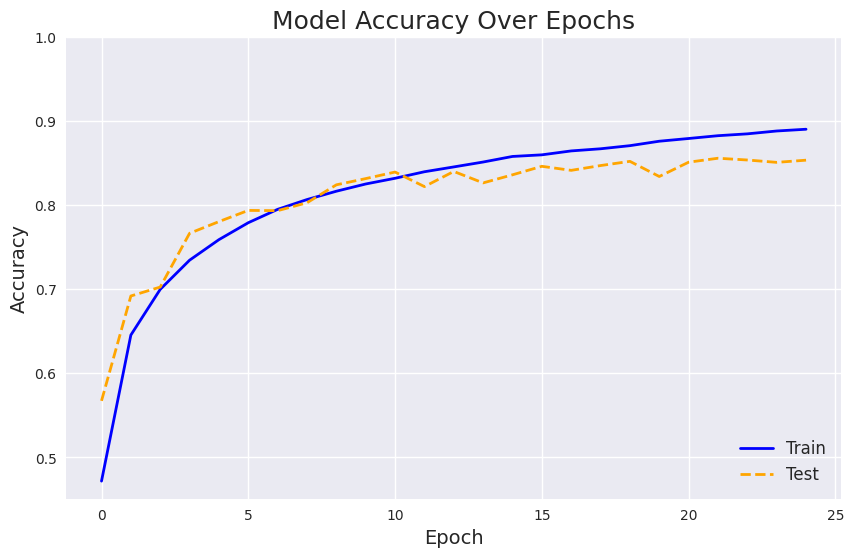

In [0]:
# Plot training & validation accuracy values
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Test', color='orange', linestyle='--', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

/root/.ipykernel/1365/command-1522013142959283-2814804683:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


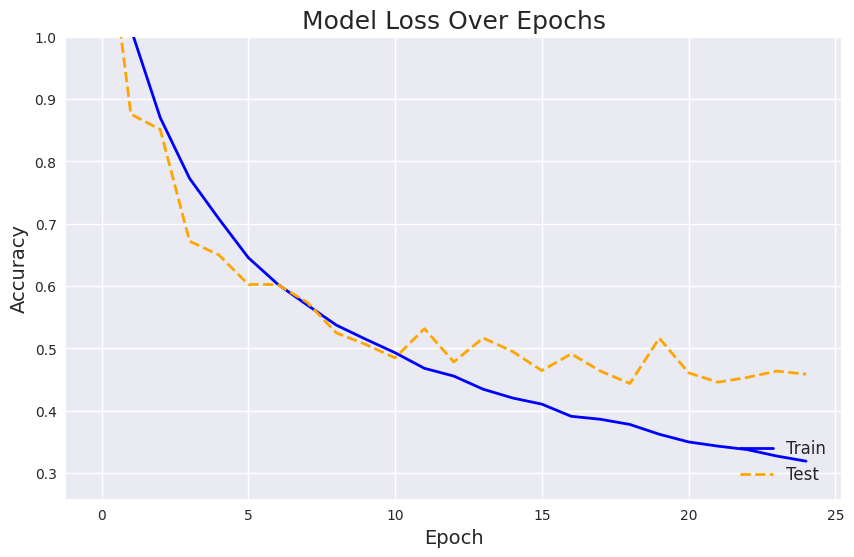

In [0]:
# Plot training & validation accuracy values
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Test', color='orange', linestyle='--', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='lower right', fontsize=12)
sns.despine()
plt.show()

In [0]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

313/313 [==============================] - 6s 19ms/step


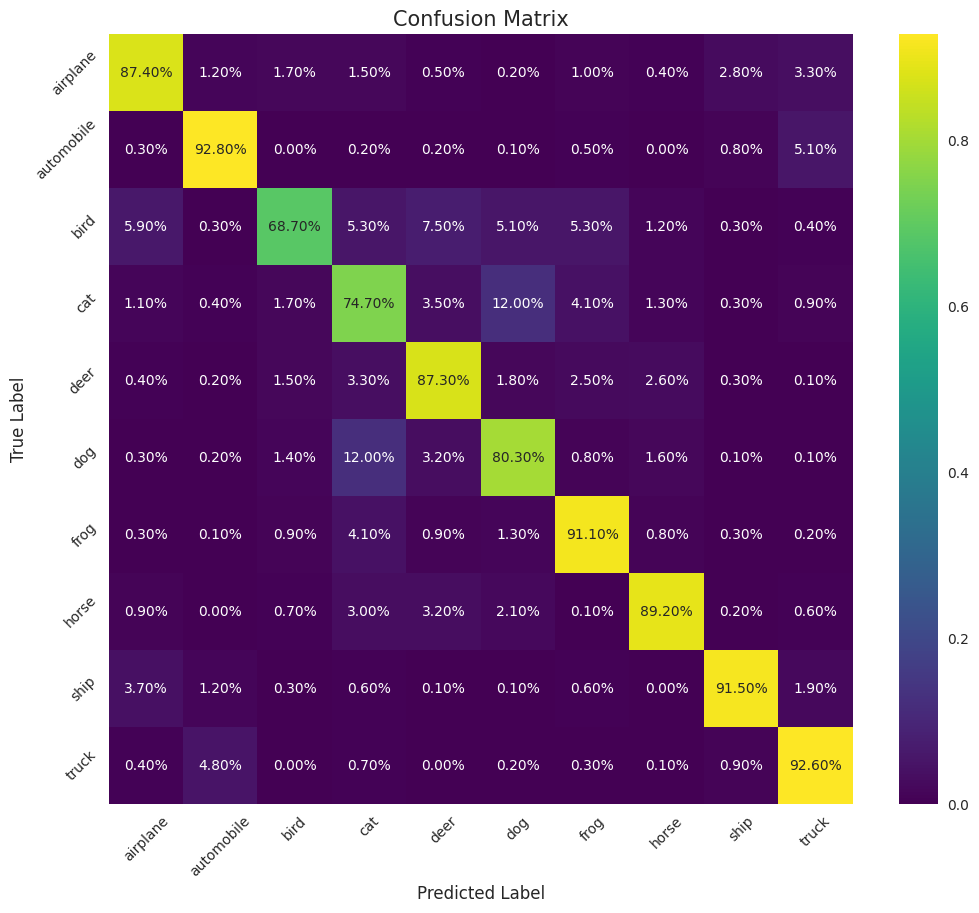

In [0]:
# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))  # Larger figure size
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label', fontsize=12)  
plt.ylabel('True Label', fontsize=12)      
plt.title('Confusion Matrix', fontsize=15)  
plt.xticks(rotation=45)  
plt.yticks(rotation=45)  
plt.show()